In [42]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import itertools

# Data Preprocessing

In [3]:
data_path = '../data/'

# image preprocessing to change to tensor, and pixel values between (-1, 1), to be comparable with GAN generator output image in range of (-1, 1) using tanh
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

mnist_dataset = torchvision.datasets.MNIST(root=data_path, train=True, transform=transform, download=False)

# check one sample
example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [6]:
# function to create the random input to the generator (usually uniform or normal distribution)
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

In [30]:
# create dataloader
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
mnist_dl = DataLoader(mnist_dataset, batch_size, shuffle=True, drop_last=True)

# Model

In [31]:
# function for generator model
def make_generator_network(input_size=20, num_hidden_layers=1, num_hidden_units=100, num_output_units=784):
    model = nn.Sequential()
    
    # add the hidden FC layers for the generator
    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units))
        model.add_module(f'relu_g{i}', nn.LeakyReLU())  # GAN usually uses leaky Relu
        input_size = num_hidden_units
    
    # output layer
    model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('tanh_g', nn.Tanh())  # generator usually uses tanh as it helps learning

    return model

# function for discriminator model
def make_discriminator_network(input_size, num_hidden_layers=1, num_hidden_units=100, num_output_units=1):
    model = nn.Sequential()
    
    # add the hidden FC layers for the discriminator
    for i in range(num_hidden_layers):
        model.add_module(f'fc_d{i}', nn.Linear(input_size, num_hidden_units))
        model.add_module(f'relu_d{i}', nn.LeakyReLU())  # GAN usually uses leaky Relu
        model.add_module('dropout', nn.Dropout(p=0.5))  # discriminator adds a dropout layer after each FC layer
        input_size = num_hidden_units
    
    # output layer
    model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('sigmoid', nn.Sigmoid())  # sigmoid for binary output probability (real vs fake)

    return model

In [32]:
image_size = (28, 28)
z_size = 20  # simple model, only use input vector of 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

torch.manual_seed(1)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

# create gen and disc models
gen_model = make_generator_network(input_size=z_size, num_hidden_layers=gen_hidden_layers, num_hidden_units=gen_hidden_size, num_output_units=np.prod(image_size)).to(device)
disc_model = make_discriminator_network(input_size=np.prod(image_size), num_hidden_layers=disc_hidden_layers, num_hidden_units=disc_hidden_size).to(device)

print(gen_model)
print(disc_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)
Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=True)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# Train

In [38]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

mode_z = 'uniform'  # or normal

In [39]:
# function to train the generator
def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)

    # create random input for generator
    input_z = create_noise(batch_size, z_size, mode_z).to(device)

    # generate
    g_output = gen_model(input_z)

    # discriminate
    d_proba_fake = disc_model(g_output)

    # we want generators to generate close-to-real images, so the GT label is 1
    g_labels_real = torch.ones(batch_size, 1, device=device)

    # calculate error
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # optimzie the generator
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

# function to train the discriminator
def d_train(x):
    disc_model.zero_grad()

    # train discriminator with real batch
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_proba_real = disc_model(x)

    # GT on real images is 1
    d_labels_real = torch.ones(batch_size, 1, device=device)

    # caculate error on real images
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # train discriminator with generated batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)

    # GT on generated image is 0
    d_labels_fake = torch.zeros(batch_size, 1, device=device)

    # calculate error on generated images
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # optimize the discriminator
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()


In [40]:
# create a fixed input so we can check the output of generator on the same input over the training epochs
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

# function to generate some sample images, given an input
def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1) / 2.0

In [41]:
epoch_samples = []  # keep track of the samples generated at each epoch using the same input
all_d_losses = []
all_g_losses = []
all_d_proba_real = []
all_d_proba_fake = []
num_epochs = 100

for epoch in range(1, num_epochs+1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []

    # for each batch in the dataset
    for i, (x, _) in enumerate(mnist_dl):
        # train the discriminator
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        # keep track of errors
        d_losses.append(d_loss)

        # train the generator
        g_loss = g_train(x)
        # keep track of errors
        g_losses.append(g_loss)

        # keep track of discriminators proba on real and generated images (more training would reach a 0.5/0.5 proba, as the generated images become indistinguishable as real images)
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    # keep track of metrics for this epoch
    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_proba_real.append(torch.tensor(d_vals_real).mean())
    all_d_proba_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch:03d} | Avg Losses >> G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f} [D-Real: {all_d_proba_real[-1]:.4f} D-Fake: {all_d_proba_fake[-1]:.4f}]')

    # generate some samples to visualize generator output
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 13.3770/0.0238 [D-Real: 0.9914 D-Fake: 0.0102]
Epoch 002 | Avg Losses >> G/D 8.5254/0.1708 [D-Real: 0.9379 D-Fake: 0.0591]
Epoch 003 | Avg Losses >> G/D 3.8882/0.3921 [D-Real: 0.8772 D-Fake: 0.1404]
Epoch 004 | Avg Losses >> G/D 2.1088/0.6282 [D-Real: 0.8072 D-Fake: 0.2082]
Epoch 005 | Avg Losses >> G/D 1.5940/0.7900 [D-Real: 0.7509 D-Fake: 0.2617]
Epoch 006 | Avg Losses >> G/D 1.3393/0.9162 [D-Real: 0.7033 D-Fake: 0.3062]
Epoch 007 | Avg Losses >> G/D 1.3132/0.9677 [D-Real: 0.6787 D-Fake: 0.3248]
Epoch 008 | Avg Losses >> G/D 1.1958/1.0488 [D-Real: 0.6482 D-Fake: 0.3559]
Epoch 009 | Avg Losses >> G/D 1.1735/1.0848 [D-Real: 0.6351 D-Fake: 0.3703]
Epoch 010 | Avg Losses >> G/D 1.1394/1.0966 [D-Real: 0.6267 D-Fake: 0.3768]
Epoch 011 | Avg Losses >> G/D 1.1511/1.1048 [D-Real: 0.6232 D-Fake: 0.3800]
Epoch 012 | Avg Losses >> G/D 1.4617/1.0020 [D-Real: 0.6595 D-Fake: 0.3400]
Epoch 013 | Avg Losses >> G/D 1.8902/0.8829 [D-Real: 0.7071 D-Fake: 0.3091]
Epoch 014 |

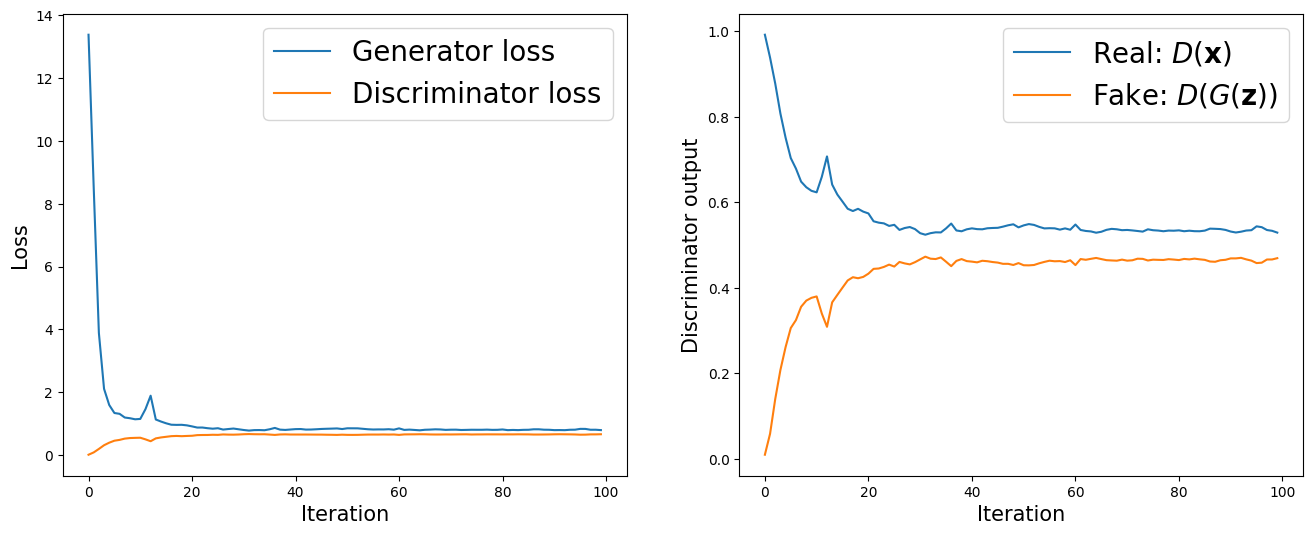

In [43]:
fig = plt.figure(figsize=(16, 6))

# plot error
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

# plot discriminator prob on real and generated images
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_proba_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_proba_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

plt.show()

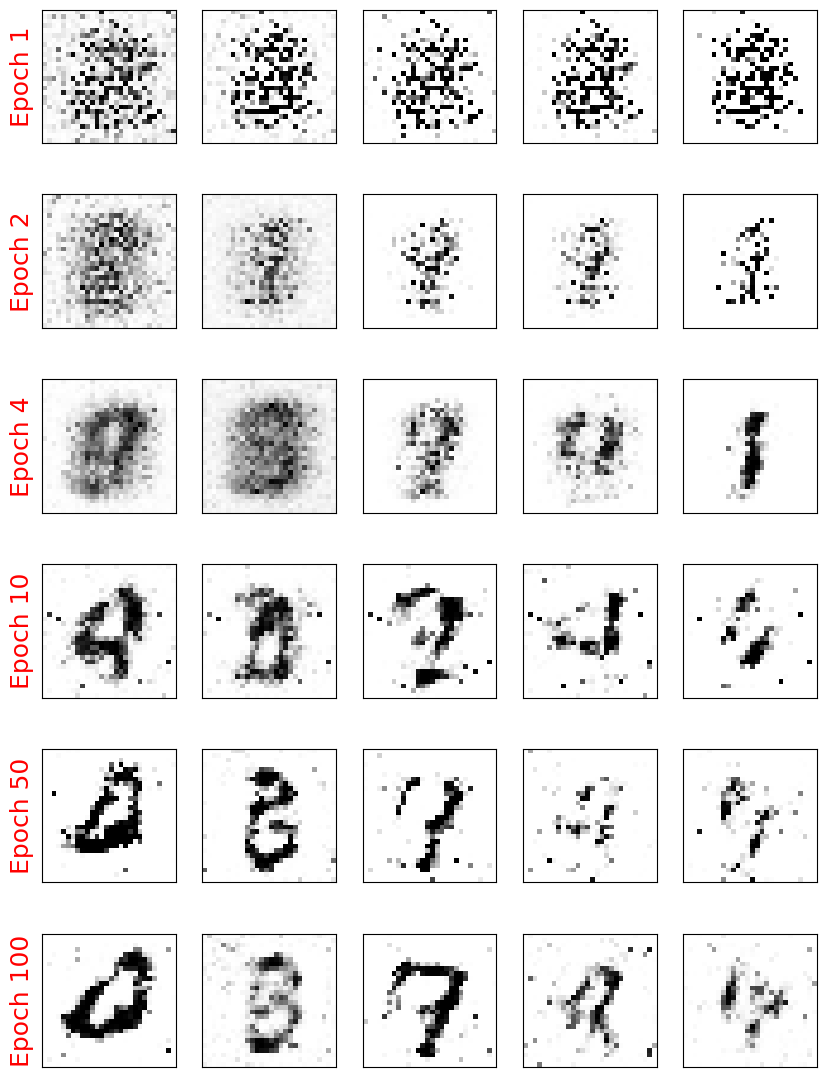

In [44]:
# plot some generator images over the epochs
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.show()